In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)


def relu(x):
    return x * (x > 0)


def sigmoid(A):
    return 1 / (1 + np.exp(-A))


def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)


def sigmoid_cost(T, Y):
    return -(T*np.log(Y) + (1-T)*np.log(1-Y)).sum()


def cost(T, Y):
    return -(T*np.log(Y)).sum()


def cost2(T, Y):
    # same as cost(), just uses the targets to index Y
    # instead of multiplying by a large indicator matrix with mostly 0s
    N = len(T)
    return -np.log(Y[np.arange(N), T]).mean()


def error_rate(targets, predictions):
    return np.mean(targets != predictions)


def y2indicator(y):
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


def getData(balance_ones=True, Ntest=1000):
    # images are 48x48 = 2304 size vectors
    Y = []
    X = []
    first = True
    for line in open('/home/mrz/MyDrive/Education/Deep-Learning/Codes/LogisticRegression/facial-expression-recognition/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    # shuffle and split
    X, Y = shuffle(X, Y)
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xvalid, Yvalid = X[-Ntest:], Y[-Ntest:]

    if balance_ones:
        # balance the 1 class
        X0, Y0 = Xtrain[Ytrain!=1, :], Ytrain[Ytrain!=1]
        X1 = Xtrain[Ytrain==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        Xtrain = np.vstack([X0, X1])
        Ytrain = np.concatenate((Y0, [1]*len(X1)))

    return Xtrain, Ytrain, Xvalid, Yvalid


def getImageData():
    Xtrain, Ytrain, Xvalid, Yvalid = getData()
    N, D = Xtrain.shape
    d = int(np.sqrt(D))
    Xtrain = Xtrain.reshape(-1, 1, d, d)
    Xvalid = Xvalid.reshape(-1, 1, d, d)
    return Xtrain, Ytrain, Xvalid, Yvalid


def getBinaryData():
    Y = []
    X = []
    first = True
    for line in open('/home/mrz/MyDrive/Education/Deep-Learning/Codes/LogisticRegression/facial-expression-recognition/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    return np.array(X) / 255.0, np.array(Y)


def crossValidation(model, X, Y, K=5):
    # split data into K parts
    X, Y = shuffle(X, Y)
    sz = len(Y) // K
    errors = []
    for k in range(K):
        xtr = np.concatenate([ X[:k*sz, :], X[(k*sz + sz):, :] ])
        ytr = np.concatenate([ Y[:k*sz], Y[(k*sz + sz):] ])
        xte = X[k*sz:(k*sz + sz), :]
        yte = Y[k*sz:(k*sz + sz)]

        model.fit(xtr, ytr)
        err = model.score(xte, yte)
        errors.append(err)
    print("errors:", errors)
    return np.mean(errors)

In [3]:
Xtrain, Ytrain, Xvalid, Yvalid = getData()

In [4]:
Xtrain.shape

(39119, 2304)

In [5]:
Xvalid.shape

(1000, 2304)

In [6]:
d = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0,}

for c in Ytrain:
    d[c] += 1
    
print(d)

{0: 4819, 1: 4761, 2: 4985, 3: 8738, 4: 5906, 5: 3881, 6: 6029}


In [7]:
class Model():

    def fit(self, X, Y, Xvalid, Yvalid, learning_rate=0.001, reg=0.0, epochs=10000, show_fig=False):
        Tvalid = y2indicator(Yvalid)

        N, D = X.shape
        K = len(set(Y))
        T = y2indicator(Y)
        
        self.W = np.random.randn(D, K) / np.sqrt(D)
        self.b = np.zeros(K)

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY = self.forward(X)
            
            # gradient descent step
            self.W -= learning_rate * ( (X.T @ (pY - T)) + reg*self.W )
            self.b -= learning_rate * ( np.sum(pY - T, axis=0) + reg*self.b )
            
            if i % 10 == 0:
                pYvalid = self.forward(Xvalid)
                c = cost(Tvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.argmax(pYvalid, axis=1))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        return softmax((X @ self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return np.argmax(pY, axis=1)

    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)


In [8]:
model = Model()

i: 0 cost: 1866.376815305006 error: 0.779
i: 10 cost: 1916.4891268632673 error: 0.765
i: 20 cost: 1914.9031384711002 error: 0.763
i: 30 cost: 1909.8424044081733 error: 0.757
i: 40 cost: 1905.1758717624134 error: 0.753
i: 50 cost: 1900.9244083114886 error: 0.751
i: 60 cost: 1897.0299650550587 error: 0.751
i: 70 cost: 1893.442560591465 error: 0.75
i: 80 cost: 1890.1205645719738 error: 0.75
i: 90 cost: 1887.0292333074412 error: 0.751
i: 100 cost: 1884.139468016749 error: 0.748
i: 110 cost: 1881.4268009212342 error: 0.747
i: 120 cost: 1878.8705703778844 error: 0.746
i: 130 cost: 1876.4532506079759 error: 0.745
i: 140 cost: 1874.1599070743302 error: 0.742
i: 150 cost: 1871.977753586542 error: 0.74
i: 160 cost: 1869.8957915833203 error: 0.742
i: 170 cost: 1867.904515732595 error: 0.742
i: 180 cost: 1865.9956730494707 error: 0.739
i: 190 cost: 1864.1620652345766 error: 0.737
i: 200 cost: 1862.39738596376 error: 0.735
i: 210 cost: 1860.6960864940206 error: 0.734
i: 220 cost: 1859.0532642613048

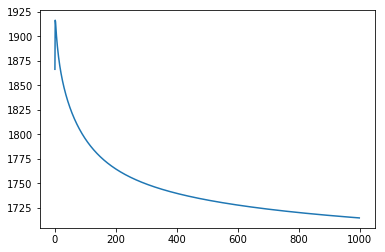

In [9]:
model.fit(Xtrain, Ytrain, Xvalid, Yvalid, learning_rate=1e-7, epochs=10000, show_fig=True)

In [10]:
print(model.score(Xvalid, Yvalid))

0.349


In [11]:
model.predict(Xvalid)

array([1, 3, 4, 4, 1, 6, 6, 0, 6, 4, 3, 3, 6, 6, 3, 5, 6, 1, 6, 3, 0, 3,
       3, 1, 1, 3, 3, 2, 2, 6, 6, 3, 1, 5, 3, 6, 3, 3, 3, 6, 6, 3, 3, 3,
       4, 3, 6, 3, 3, 5, 3, 3, 6, 3, 2, 1, 3, 3, 0, 3, 3, 4, 5, 3, 0, 3,
       6, 3, 3, 3, 5, 6, 1, 6, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 5, 3, 2, 3,
       5, 3, 5, 3, 3, 3, 6, 3, 3, 5, 6, 3, 3, 4, 2, 6, 3, 4, 6, 2, 6, 3,
       6, 3, 5, 5, 4, 5, 6, 6, 3, 5, 3, 3, 1, 6, 6, 3, 3, 3, 3, 2, 2, 3,
       4, 5, 3, 0, 3, 3, 3, 3, 3, 5, 3, 3, 4, 3, 1, 3, 4, 3, 5, 3, 3, 5,
       4, 1, 4, 3, 5, 5, 5, 6, 3, 3, 1, 1, 4, 4, 2, 1, 3, 1, 4, 1, 3, 5,
       1, 1, 1, 1, 2, 1, 4, 6, 2, 3, 3, 1, 3, 2, 1, 0, 3, 6, 2, 6, 1, 2,
       6, 3, 3, 3, 3, 1, 3, 3, 3, 2, 4, 4, 3, 0, 4, 6, 3, 3, 4, 1, 5, 3,
       1, 3, 4, 4, 4, 6, 3, 1, 6, 0, 4, 3, 4, 0, 4, 3, 3, 5, 6, 3, 4, 4,
       5, 3, 5, 4, 3, 3, 3, 4, 2, 6, 3, 3, 4, 6, 6, 6, 5, 5, 3, 5, 3, 3,
       4, 3, 1, 3, 4, 2, 6, 3, 1, 3, 6, 3, 4, 4, 3, 1, 6, 3, 2, 3, 3, 3,
       5, 3, 3, 1, 5, 3, 6, 3, 6, 6, 5, 3, 5, 4, 3,

In [12]:
Yvalid

array([4, 4, 5, 2, 2, 0, 6, 3, 3, 0, 2, 6, 6, 2, 3, 2, 6, 2, 6, 6, 2, 3,
       4, 4, 3, 4, 2, 5, 3, 6, 2, 6, 0, 3, 5, 0, 3, 6, 6, 4, 5, 0, 4, 3,
       6, 6, 6, 3, 3, 5, 5, 4, 6, 6, 4, 6, 6, 2, 5, 0, 2, 4, 5, 0, 0, 0,
       3, 3, 6, 5, 2, 6, 0, 2, 4, 3, 6, 6, 3, 3, 0, 3, 3, 3, 6, 3, 2, 0,
       5, 0, 3, 0, 2, 4, 0, 3, 5, 4, 6, 3, 0, 4, 3, 3, 6, 0, 6, 2, 2, 3,
       6, 2, 5, 5, 2, 0, 2, 2, 5, 5, 0, 3, 0, 5, 2, 3, 3, 3, 4, 5, 4, 0,
       4, 6, 1, 0, 0, 0, 3, 3, 4, 5, 3, 2, 4, 4, 6, 2, 4, 3, 2, 2, 3, 4,
       2, 2, 4, 3, 5, 0, 6, 6, 4, 5, 3, 5, 1, 0, 2, 5, 0, 6, 5, 5, 0, 5,
       2, 3, 4, 4, 2, 6, 6, 6, 2, 3, 3, 5, 3, 4, 4, 0, 4, 4, 3, 5, 0, 5,
       6, 3, 3, 0, 2, 3, 6, 6, 0, 6, 6, 4, 3, 4, 4, 5, 3, 0, 4, 4, 3, 3,
       3, 6, 2, 1, 4, 3, 3, 4, 4, 0, 2, 5, 6, 0, 4, 2, 3, 5, 2, 3, 4, 2,
       5, 3, 5, 2, 6, 3, 6, 3, 5, 0, 3, 4, 6, 6, 1, 4, 4, 4, 0, 2, 6, 3,
       5, 3, 5, 6, 4, 3, 0, 3, 3, 3, 0, 0, 4, 4, 1, 0, 6, 5, 3, 3, 3, 4,
       5, 3, 0, 0, 6, 3, 2, 3, 2, 4, 5, 4, 5, 2, 4,

In [13]:
v = np.array([
    [.2, .3, .9],
    [.35, .45, .96],
])

In [14]:
v.argmax(axis=1)

array([2, 2])

In [18]:
np.save(arr=v)

TypeError: _save_dispatcher() missing 1 required positional argument: 'file'

In [19]:
help(np.save)

Help on function save in module numpy:

save(file, arr, allow_pickle=True, fix_imports=True)
    Save an array to a binary file in NumPy ``.npy`` format.
    
    Parameters
    ----------
    file : file, str, or pathlib.Path
        File or filename to which the data is saved.  If file is a file-object,
        then the filename is unchanged.  If file is a string or Path, a ``.npy``
        extension will be appended to the file name if it does not already
        have one.
    arr : array_like
        Array data to be saved.
    allow_pickle : bool, optional
        Allow saving object arrays using Python pickles. Reasons for disallowing
        pickles include security (loading pickled data can execute arbitrary
        code) and portability (pickled objects may not be loadable on different
        Python installations, for example if the stored objects require libraries
        that are not available, and not all pickled data is compatible between
        Python 2 and Python 3).
 

In [28]:
Xtrain.shape

(39119, 2304)

In [29]:
d = np.sqrt(2304)
d

48.0

In [39]:
v = Xtrain.reshape(-1, 3, 12, 48)
v.shape

ValueError: cannot reshape array of size 90130176 into shape (3,12,48)

In [33]:
v[0].shape

(48, 48)

NameError: name 'yp' is not defined